## Imports
***

In [1]:
import pandas as pd 
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import numpy as np
plt.rcParams["figure.figsize"] = (18,9)
import os
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
print(__version__)# requires version >= 1.9.0
import plotly
import plotly.graph_objs as go
from datetime import datetime

Using TensorFlow backend.


2.2.2


## Helper functions
***

Assumed time period is hourly on full hours.

In [2]:
def read_electricity_p(appliances = None, 
                       limit = None, 
                       rel_file_path = '/forecast-service/data/Electricity_P.csv'):
    
    """Reads Electricity_p dataset

    Args:
        appliances: devices to read.
        limit: limit the number of rows to read.
        rel_file_path: relative path to file to read.

    Returns:
        in-memory read pandas dataframe along with the appliances 
    """
    
    # NOTE: data will be provided in google cloud storage
    filename = os.path.dirname(os.getcwd()).replace(' ','\ ') + rel_file_path
    
    # define appliance which shall be displayed
    if appliances is None and limit is None:
        electricity_data = pd.read_csv(filename,sep=",")
    elif appliances is None and limit is not None:
        electricity_data = pd.read_csv(filename,sep=",", nrows = limit)
    elif appliances is not None and limit is None:
        electricity_data = pd.read_csv(filename,sep=",", usecols=(appliances+['UNIX_TS']))
    else:
        electricity_data = pd.read_csv(filename,sep=",",nrows = limit, usecols=(appliances+['UNIX_TS']))

    # conert date column into plotly-interpretable format
    electricity_data['UNIX_TS'] = pd.to_datetime(electricity_data['UNIX_TS'],unit='s').astype(datetime)
    
    # set index to date
    #electricity_data.set_index('UNIX_TS')

    # aggregate on an hour basis
    electricity_data = electricity_data \
        .groupby(electricity_data.UNIX_TS.map(lambda x: x.strftime('%Y-%m-%d %H'))) \
        .mean()

    appliances = electricity_data.columns.values
    return electricity_data, appliances


def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df


# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)


'''# invert differenced value
def inverse_difference(history, differenced):
    # invert transform
    inverted = list()
    for i in range(len(differenced)):
        value = differenced[i] + history[-(len(history)-i)]
        inverted.append(value)
    inverted = pd.Series(inverted)
    return inverted'''

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]
 
# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scale
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    series_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, series_scaled, test_scaled
 
'''# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]'''


def invert_scale(scaler, predictions):
    array = [[a[0]] + [b[0]] for a, b in zip(predictions, predictions)]
    array = np.array(array)
    #array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted#[:,-1]

 
def invert_normalize(scaler, series_raw, series_predictions):
    series_predictions = invert_scale(scaler, series_predictions)
    # invert transform
    tmp = list()
    for i in range(len(series_predictions)):
        #if i < 10:
        #    print("step " + str(i))
        #    print("series_predictions[i]" + str(series_predictions[i]))
        #    print(series_raw[-(len(series_raw)-i)])
        value = inverse_difference(series_raw, series_predictions[i], len(series_raw)-i)
        #if i < 10:
        #    print(value)
        tmp.append(value)
    series_predictions = pd.Series(tmp)
    series_predictions = [x[0]  for x in series_predictions]
    return series_predictions


def compute_rmse(series_raw, series_predictions):
    rmse = sqrt(mean_squared_error(series_raw[1:(1+len(series_predictions))], series_predictions))
    return rmse
    
    
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons, scaler, train_raw, test_raw):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    train_err_hist = []
    test_err_hist = []
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
        model.reset_states()
        train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
        train_predictions = model.predict(train_reshaped, batch_size=1)
        train_predictions = invert_normalize(scaler, train_raw, train_predictions)
        #train_err_hist.append(compute_rmse(mean_squared_error(train_raw[1:]train_predictions[:-1]))
        #test_reshaped = test_scaled[:, 0].reshape(len(test_scaled), 1, 1)
        #test_predictions_scaled = model.predict(test_reshaped, batch_size=1)
        #test_predictions = invert_normalize(scaler, test_scaled, raw_values, test_predictions_scaled)
        #test_err_hist.append(sqrt(mean_squared_error(raw_values[n_train:(n_train+n_test)], list(test_predictions))))
        #test_raw = raw_values[-n_test:]
        #test_reshaped = test_scaled[:, 0].reshape(len(test_scaled), 1, 1)
        #test_predictions_scaled = lstm_model.predict(test_reshaped, batch_size=1)
        #test_predictions = invert_normalize(scaler, test_raw, test_predictions_scaled)
                              
    return model, train_err_hist, train_predictions

In [22]:
test_scaled

array([[-0.01535016,  0.16670555],
       [ 0.16670555, -0.22782625],
       [-0.22782625,  0.19432651],
       ..., 
       [ 0.02804087, -0.07852377],
       [-0.07852377, -0.08458918],
       [-0.08458918,  0.19357999]])

## Forecasting
***

###### Read data


In [3]:
plotly.offline.init_notebook_mode(connected=True)

electricity_data, appliances= read_electricity_p(appliances = ['FGE'])

In [4]:
electricity_data.tail(10)

,FGE
UNIX_TS,
2014-03-31 21,64.250000
2014-03-31 22,47.400000
2014-03-31 23,59.533333
2014-04-01 00,92.283333
2014-04-01 01,51.000000
2014-04-01 02,47.683333
2014-04-01 03,53.616667
2014-04-01 04,40.516667
2014-04-01 05,26.333333


###### LSTM Data Preparation
###### Transform Time Series to Supervised Learning

In [5]:
# transform data to be stationary
raw_values = electricity_data.values
diff_values = difference(raw_values, 1)

In [6]:
 # transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

In [7]:
 # split data into train and test-sets
test_portion = 0.1
n = len(supervised_values)
train, test = supervised_values[0:-int(n*test_portion)], supervised_values[-int(n*test_portion):]
print('Train shape:  {}\nTest shape:  {}'.format(train.shape, test.shape))

Train shape:  (15768, 2)
Test shape:  (1751, 2)


In [8]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

/Users/kevinstrau/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning:

Data with input dtype object was converted to float64 by MinMaxScaler.



###### Baseline Model

###### Train Error

In [9]:
n_train = len(train[:,0])
n_train
train[n_train-1,0]
train_raw = raw_values[:n_train]

RMSE: 35.436


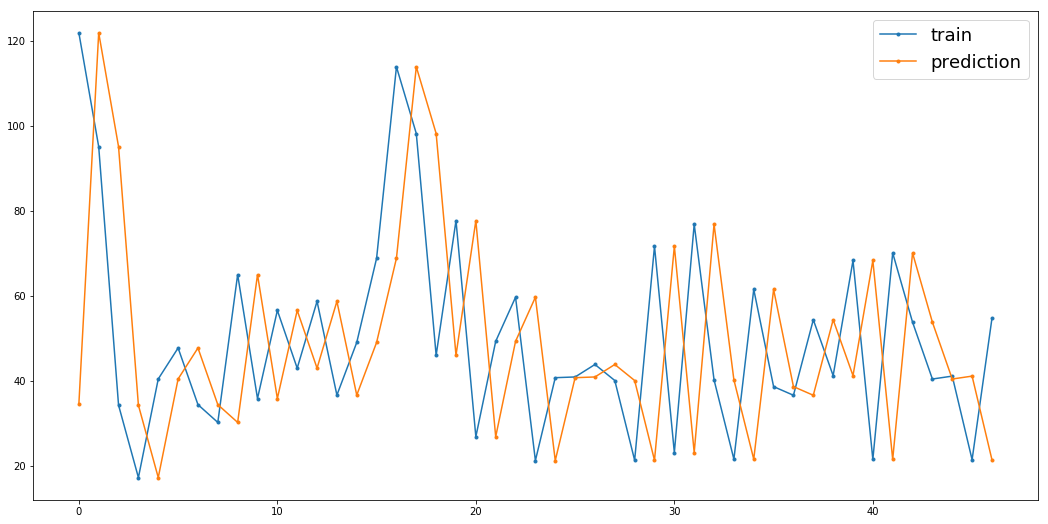

In [10]:
train_cut = raw_values[1:n_train]
prediction = raw_values[0:(n_train-1)]
n_cut = len(train_cut)

# report performance
rmse = sqrt(mean_squared_error(train_cut, prediction))
print('RMSE: %.3f' % rmse)
# line plot of observed vs predicted
section = [0.95,0.953]
plt.plot(train_cut[int(n_cut*section[0]):int(n_cut*section[1])],'.-')
plt.plot(prediction[int(n_cut*section[0]):int(n_cut*section[1])],'.-')
plt.gca().legend(('train','prediction'), prop={'size': 18})
plt.show()

###### Test Error

RMSE: 33.754


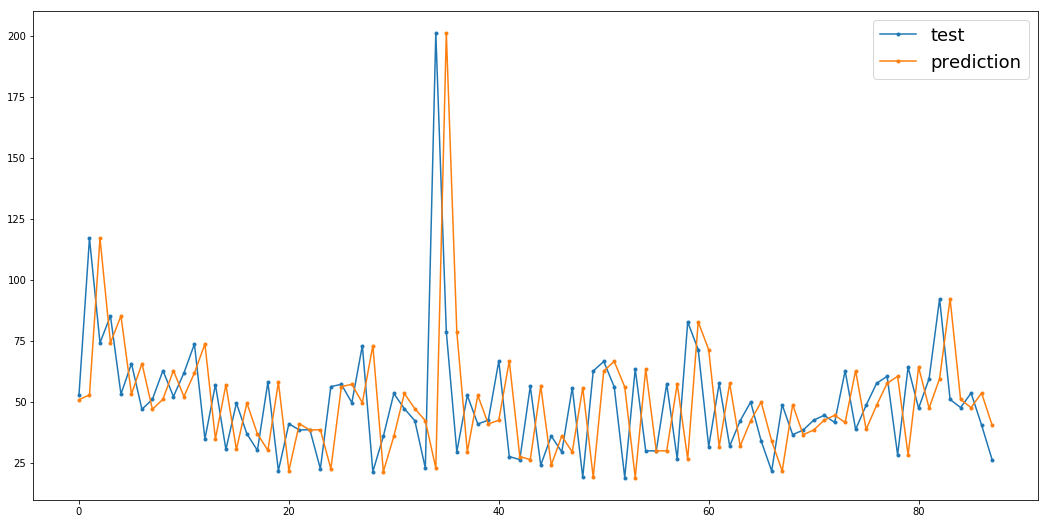

In [11]:
n_test = len(test)
test_raw = raw_values[-(n_test+2):]


base_pred = raw_values[(n_train-1):(n_train+n_test-1)]

# report performance
rmse = sqrt(mean_squared_error(raw_values[n_train:(n_train+n_test)], base_pred))
print('RMSE: %.3f' % rmse)
# line plot of observed vs predicted
section = [0.95,1]
plt.plot(raw_values[int((n_train+section[0]*n_test)):int((n_train+section[1]*n_test))],'.-')
plt.plot(base_pred[int(n_test*section[0]):int(n_test*section[1])],'.-')
plt.gca().legend(('test','prediction'), prop={'size': 18})
plt.show()

###### LSTM Model

In [12]:
# fit the model
#def fit_lstm(train, batch_size, nb_epoch, neurons, scaler, train_raw, test_raw):


lstm_model, train_err_hist, train_predictions = fit_lstm(train_scaled, 1, 1, 20, scaler, train_raw, test_raw)


Epoch 1/1
15768/15768 [==============================] - 93s 6ms/step - loss: 0.0209


In [13]:
train_predictions[:5]

[43.331883335113524,
 44.167840067545576,
 47.354412714640304,
 32.535788472493486,
 41.434378941853844]

###### Train Error

15768
15768
RMSE: 25.413


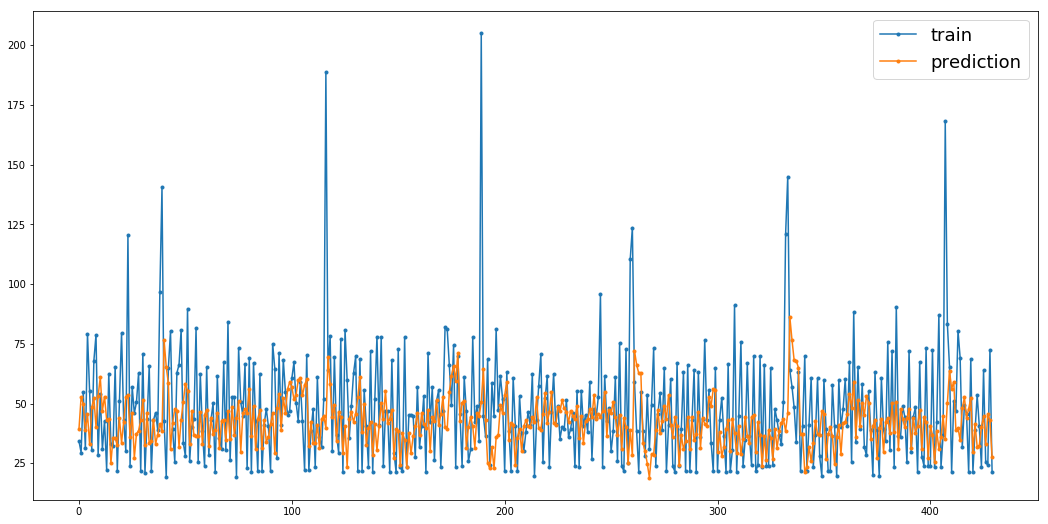

In [36]:
#train_inverted_scale = invert_scale(scaler, train_scaled[1:])
#inverted_train_raw = invert_normalize(scaler, train_raw, train_scaled[1:])
print(len(train_raw))
print(len(train_predictions))
rmse = sqrt(mean_squared_error(train_raw[1:], train_predictions[:-1]))
print('RMSE: %.3f' % rmse)
t = 3
a=t*100
b=t*100+430
plt.plot(list(train_raw[1:][a:b]),'.-')
plt.plot(list(train_predictions[:-1][a:b]),'.-')
plt.gca().legend(('train','prediction'), prop={'size': 18})
plt.show()

###### Test Error

In [34]:
test_raw = raw_values[-n_test:]
test_reshaped = test_scaled[:, 0].reshape(len(test_scaled), 1, 1)
test_predictions_scaled = lstm_model.predict(test_reshaped, batch_size=1)
test_predictions = invert_normalize(scaler, test_raw, test_predictions_scaled)

1751
1751
RMSE: 25.628


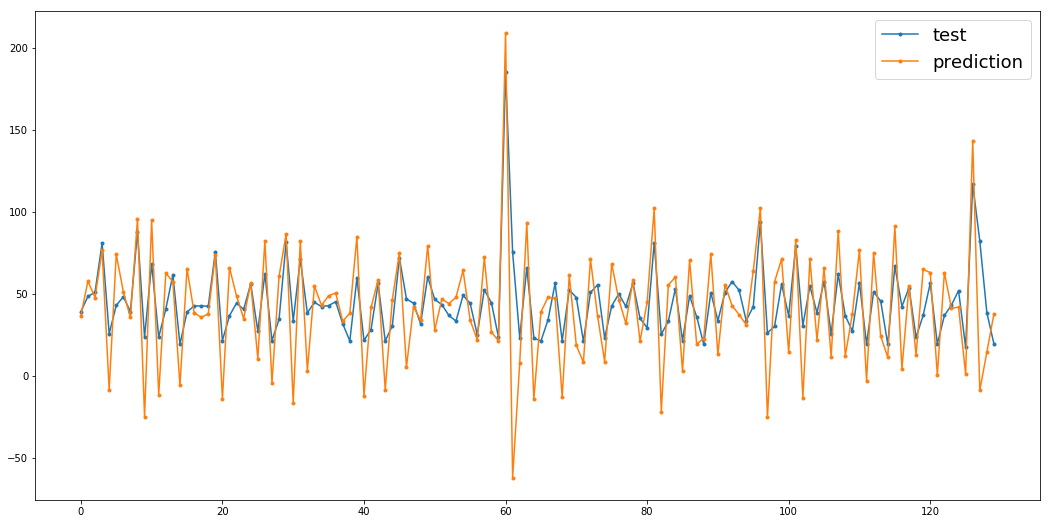

In [35]:
test_raw = raw_values[-n_test:]
print(len(test_raw))
print(len(test_predictions))
rmse = sqrt(mean_squared_error(test_raw, test_predictions))
print('RMSE: %.3f' % rmse)
t = 3
a=t*100
b=t*100+130
plt.plot(list(test_raw[a:b]),'.-')
plt.plot(list(test_predictions[a:b]),'.-')
plt.gca().legend(('test','prediction'), prop={'size': 18})
plt.show()

raw_scaled has 2 columns: 
1. 0 - N-1
2. 1 - N

In [44]:
raw_scaled = np.concatenate((train_scaled, test_scaled), axis=0)
raw_reshaped = raw_scaled[:, 0].reshape(len(raw_scaled), 1, 1)
raw_predictions_scaled = lstm_model.predict(raw_reshaped, batch_size=1)
raw_predictions = invert_normalize(scaler, raw_values, raw_predictions_scaled)

In [57]:
raw_scaled

array([[-0.00517893, -0.02944058],
       [-0.02944058, -0.12219475],
       [-0.12219475,  0.18947418],
       ..., 
       [ 0.02804087, -0.07852377],
       [-0.07852377, -0.08458918],
       [-0.08458918,  0.19357999]])

17519
17520
17519
TRAIN RMSE: 25.414
TEST RMSE: 24.143


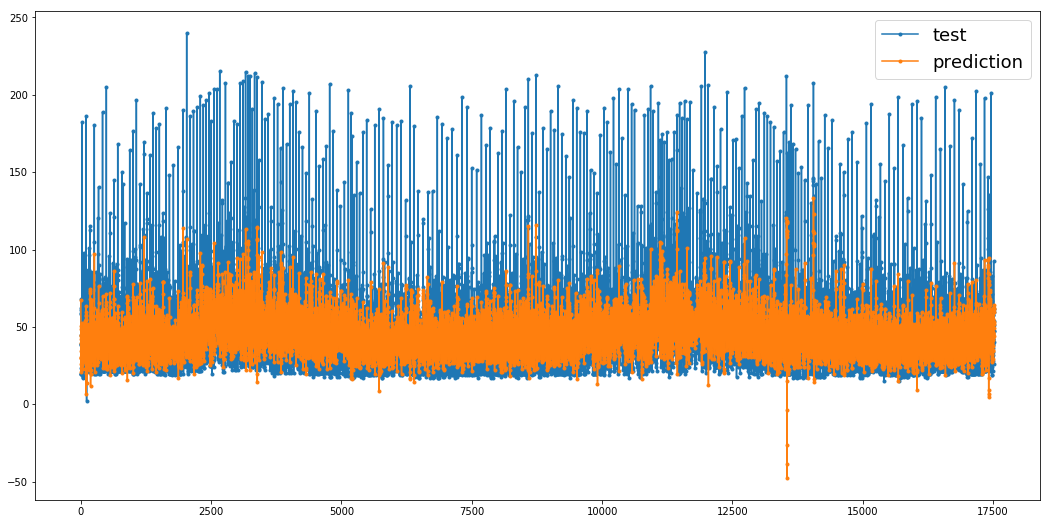

In [61]:
print(len(raw_scaled))
print(len(raw_values))
print(len(raw_predictions))
rmse = sqrt(mean_squared_error(raw_values[1:][:n_train], raw_predictions[:n_train]))
print('TRAIN RMSE: %.3f' % rmse)

rmse = sqrt(mean_squared_error(raw_values[1:][n_train:n_train+n_test], raw_predictions[n_train:n_train+n_test]))
print('TEST RMSE: %.3f' % rmse)
t = 3
a=14000
b=17500
plt.plot(list(raw_values[1:]),'.-')
plt.plot(list(raw_predictions[:-1]),'.-')
plt.gca().legend(('test','prediction'), prop={'size': 18})
plt.show()

###### Controll Invertion on Train

15768
15767
RMSE: 0.000


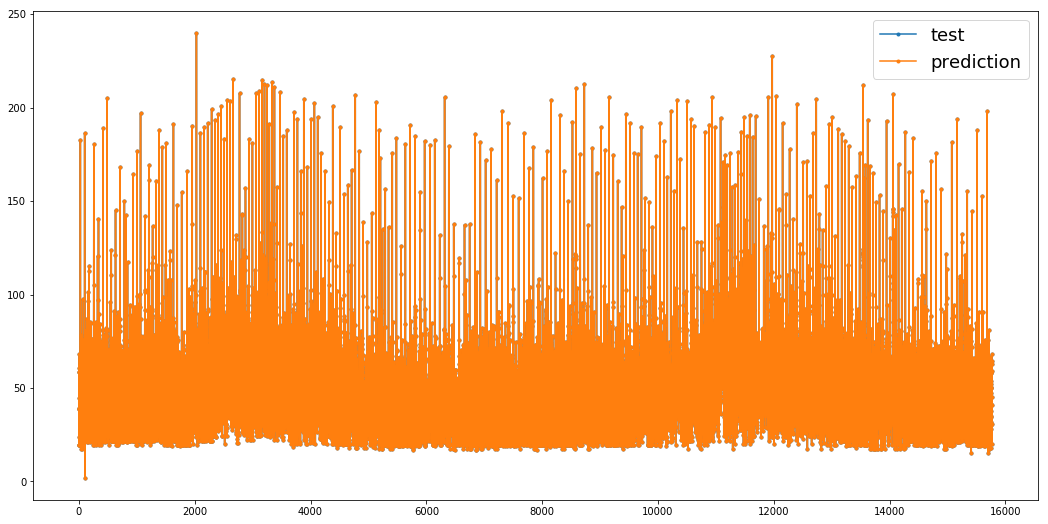

In [17]:
train_raw = raw_values[:n_train]
#train_inverted_scale = invert_scale(scaler, train_scaled[1:])
inverted_train_raw = invert_normalize(scaler, train_raw, train_scaled[1:])
print(len(train_raw))
print(len(inverted_train_raw))
rmse = sqrt(mean_squared_error(train_raw[1:], inverted_train_raw))
print('RMSE: %.3f' % rmse)
t = 3
a=t*100
b=t*100+130
plt.plot(list(train_raw[1:]),'.-')
plt.plot(list(inverted_train_raw),'.-')
plt.gca().legend(('test','prediction'), prop={'size': 18})
plt.show()

###### Controll Invertion on Test

1753
1751
RMSE: 0.000


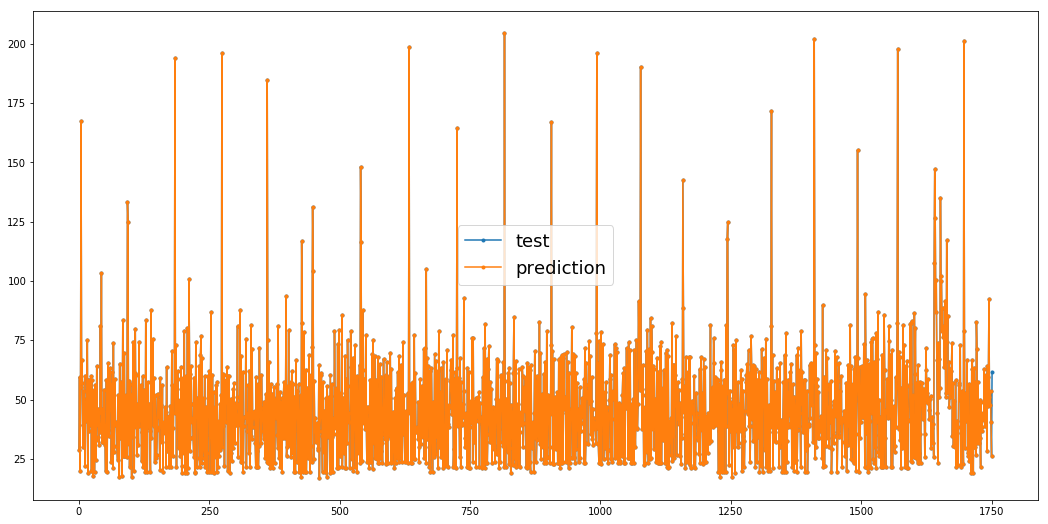

In [18]:
test_raw = raw_values[-(n_test+2):]
inverted_test_raw = invert_normalize(scaler, test_raw, test_scaled)
print(len(test_raw))
print(len(inverted_test_raw))
rmse = sqrt(mean_squared_error(test_raw[1:-1], inverted_test_raw))
print('RMSE: %.3f' % rmse)
t = 3
a=t*100
b=t*100+130
plt.plot(list(test_raw[1:]),'.-')
plt.plot(list(inverted_test_raw),'.-')
plt.gca().legend(('test','prediction'), prop={'size': 18})
plt.show()

In [25]:
train_scaled[-2:]

array([[ 0.24368964, -0.19330005],
       [-0.19330005, -0.01535016]])

In [30]:
test_scaled[:2]

array([[-0.01535016,  0.16670555],
       [ 0.16670555, -0.22782625]])

In [27]:
train[-2:]

array([[array([ 44.45]), array([-33.6])],
       [array([-33.6]), array([-1.81666667])]], dtype=object)

In [29]:
test[:2]

array([[array([-1.81666667]), array([ 30.7])],
       [array([ 30.7]), array([-39.76666667])]], dtype=object)

In [ ]:
train_